In [1]:
fdir = "../hanglog/mild_swinging"

import os, sys
sys.path.append("..")
import hacktrack.loaders
import pandas, numpy, math
from scipy import optimize
from matplotlib import pyplot as plt
from hacktrack import loaders, utils
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib notebook

logfiles = os.listdir(fdir)
print(logfiles)
fLog = os.path.join(fdir, logfiles[0])
fd = loaders.FlyDat(fLog)
fd.LoadC("ZY")

['hdata-2021-01-05_19-24-22.log']
Extracting knowndate from filename: 2021-01-05
E:1, Y:17596, Z:17374, aZ:1026, aA:1026, aF:1009
linAdifftime 28119431.929856114 count 1112
Made for Q 0 last index 0
Made for V 0 last index 0
Loading aQV as no pQV records
Made for aQ 0 last index 0
Made for aV 0 last index 0
Missing GPS data, so setting t0 to 2021-01-05 19:22:58.029930
Made for Z 17374 last index 17374
Warning, using guessed (not GPS) timing corrected value on Z 17374
pCattrname pZ
Made for Y 17596 last index 17596
Warning, using guessed (not GPS) timing corrected value on Y 17596
pCattrname pY


2

<IPython.core.display.Javascript object>


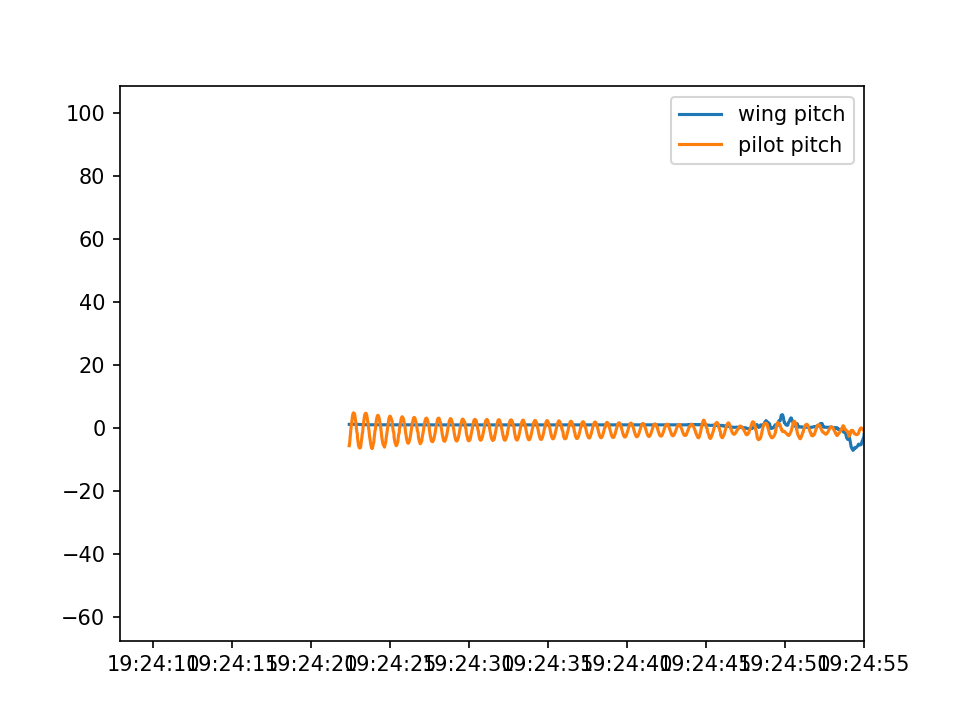

In [2]:
pilot = fd.pZ[~fd.pZ.bad]
wing = fd.pY[~fd.pY.bad]
wing.insert(6,'gx_app',wing['ax']+wing['gx'],)
wing.insert(7,'gy_app',wing['ay']+wing['gy'],)
wing.insert(8,'gz_app',wing['az']+wing['gz'],)


fig = plt.figure()
plt.plot(wing.pitch, label = 'wing pitch')
#plt.plot(wing.heading, label = 'wing heading')
plt.plot(pilot.pitch, label = 'pilot pitch')
#plt.plot(pilot.heading, label = 'pilot heading')
plt.legend()

In [3]:
#Apparent g force in world reference frame:
g_app_vec_wing = utils.qvec((wing.q0,-wing.q1,-wing.q2,-wing.q3),(wing.gx_app,wing.gy_app,wing.gz_app))
g_appx_wing = utils.curvefitdifferentiate(g_app_vec_wing[0], 0.18)[0]
print('Done x')
g_appy_wing = utils.curvefitdifferentiate(g_app_vec_wing[1], 0.18)[0]
print('Done y')
g_appz_wing = utils.curvefitdifferentiate(g_app_vec_wing[2], 0.18)[0]
print('Done z')

Done x
Done y
Done z


In [4]:
g_appx_wingI = utils.InterpT(pilot, g_appx_wing)
g_appy_wingI = utils.InterpT(pilot, g_appy_wing)
g_appz_wingI = utils.InterpT(pilot, g_appz_wing)
g_app_vec_wingI = (g_appx_wingI,g_appy_wingI,g_appz_wingI)

In [5]:
cali = (0.00872085, -0.00682147, -0.36515998)
ang_vec_pilot = utils.qvec((pilot.q0,-pilot.q1,-pilot.q2,-pilot.q3),cali)

In [6]:
vcali=(pandas.Series([0.00872085]*len(ang_vec_pilot[0]), index = ang_vec_pilot[0].index),
       pandas.Series([-0.00682147]*len(ang_vec_pilot[0]), index = ang_vec_pilot[0].index),
       pandas.Series([-0.36515998]*len(ang_vec_pilot[0]), index = ang_vec_pilot[0].index))
#vcali

In [7]:
swing_ang = utils.vecAngSeries(ang_vec_pilot,vcali)
g_app_ang = utils.vecAngSeries(g_app_vec_wingI,vcali)
g_swing_ang = utils.vecAngSeries(ang_vec_pilot,g_app_vec_wingI)

In [8]:
pilot_acc = (pilot.ax**2 + pilot.ay**2)**0.5
pilot_accF = utils.curvefitdifferentiate(pilot_acc, 0.18)[0]

In [9]:
g_app_mod_wingI = utils.vecModSeries(g_app_vec_wingI)

In [10]:
pilot_acc_calc = g_app_mod_wingI * numpy.sin(g_swing_ang)
err = pilot_acc_calc - pilot_accF

<IPython.core.display.Javascript object>


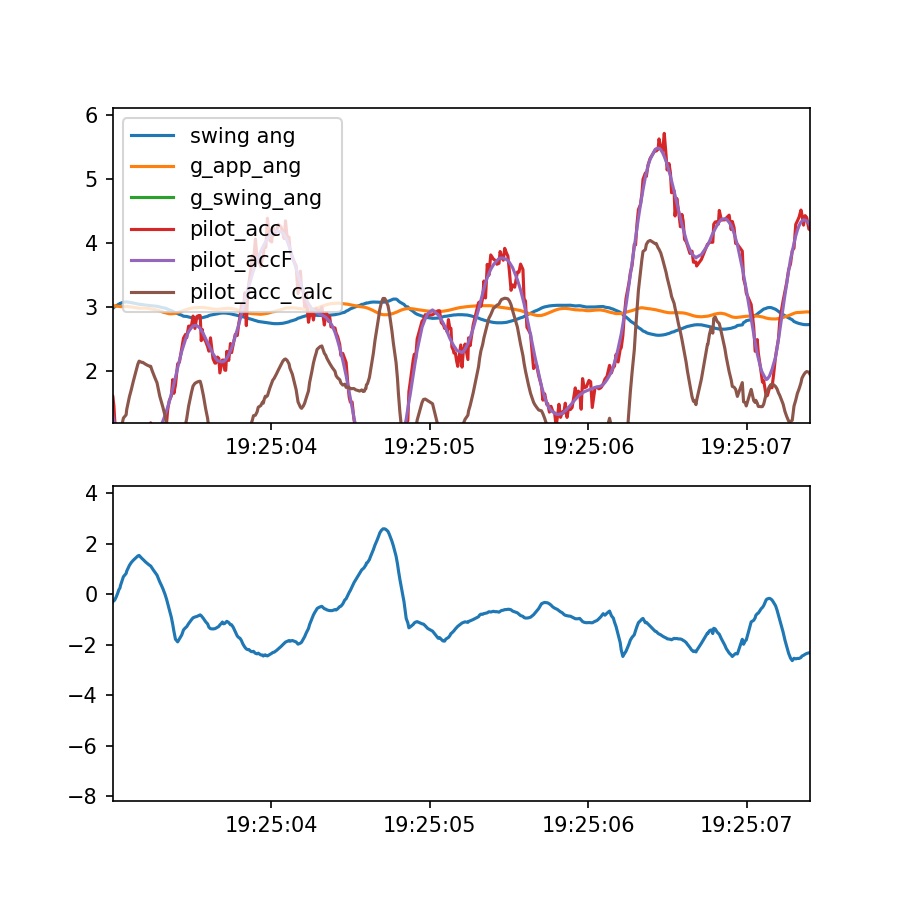

In [11]:
fig = plt.figure(figsize = (6,6))
main = plt.subplot(211)
plt.plot(swing_ang, label ='swing ang')
plt.plot(g_app_ang, label ='g_app_ang')
plt.plot(g_swing_ang, label = 'g_swing_ang')
plt.plot(pilot_acc, label = 'pilot_acc')
plt.plot(pilot_accF, label = 'pilot_accF')
plt.plot(pilot_acc_calc, label = 'pilot_acc_calc')
plt.legend()
plt.subplot(212, sharex = main)
plt.plot(err)


In [29]:
t1 = pandas.Timestamp('2021-01-05 19:24:45')
pilot_short = pilot[:t1]
wing_short = wing[:t1]
g_app_vec_wing_short = utils.qvec((wing_short.q0,-wing_short.q1,-wing_short.q2,-wing_short.q3),(wing_short.gx_app,wing_short.gy_app,wing_short.gz_app))
g_appx_wing_short = utils.curvefitdifferentiate(g_app_vec_wing_short[0], 0.18)[0]
print('Done x')
g_appy_wing_short = utils.curvefitdifferentiate(g_app_vec_wing_short[1], 0.18)[0]
print('Done y')
g_appz_wing_short = utils.curvefitdifferentiate(g_app_vec_wing_short[2], 0.18)[0]
print('Done z')
g_appx_wingI_short = utils.InterpT(pilot_short, g_appx_wing_short)
g_appy_wingI_short = utils.InterpT(pilot_short, g_appy_wing_short)
g_appz_wingI_short = utils.InterpT(pilot_short, g_appz_wing_short)
g_app_vec_wingI_short = (g_appx_wingI_short,g_appy_wingI_short,g_appz_wingI_short)
g_app_mod_wingI_short = utils.vecModSeries(g_app_vec_wingI_short)
pilot_acc_short = (pilot_short.ax**2 + pilot_short.ay**2)**0.5
pilot_accF_short = utils.curvefitdifferentiate(pilot_acc_short, 0.18)[0]

Done x
Done y
Done z


In [44]:
def calc_err(cali):
    ang_vec_pilot_short = utils.qvec((pilot_short.q0,-pilot_short.q1,-pilot_short.q2,-pilot_short.q3),cali)
    g_swing_ang_short = utils.vecAngSeries(ang_vec_pilot_short,g_app_vec_wingI_short)
    pilot_acc_calc_short = g_app_mod_wingI_short * numpy.sin(g_swing_ang_short)
    err = pilot_acc_calc_short - pilot_accF_short
    print(cali)
    return sum(err**2)
optimize.minimize(calc_err, (0,0,-1),method='Nelder-Mead')
#calc_err((0,0,-1))

[ 0.  0. -1.]
[ 2.5e-04  0.0e+00 -1.0e+00]
[ 0.0e+00  2.5e-04 -1.0e+00]
[ 0.    0.   -1.05]
[ 1.66666667e-04 -2.50000000e-04 -1.03333333e+00]
[ 2.50e-04 -5.00e-04 -1.05e+00]
[ 3.33333333e-04 -3.33333333e-04 -1.06666667e+00]
[ 5.55555556e-04 -5.55555556e-04 -1.02777778e+00]
[ 8.33333333e-04 -8.33333333e-04 -1.01666667e+00]
[ 6.94444444e-04 -1.11111111e-03 -1.08888889e+00]
[ 9.16666667e-04 -1.66666667e-03 -1.13333333e+00]
[ 1.00000000e-03 -1.66666667e-03 -1.06666667e+00]
[ 0.00133333 -0.00233333 -1.06666667]
[ 0.00180556 -0.00272222 -1.09444444]
[ 0.00258333 -0.00383333 -1.11666667]
[ 0.00238889 -0.00438889 -1.19444444]
[ 0.00316667 -0.00616667 -1.28333333]
[ 0.00380556 -0.00655556 -1.17777778]
[ 0.00525 -0.009   -1.2    ]
[ 0.006      -0.01033333 -1.33333333]
[ 0.00833333 -0.01433333 -1.46666667]
[ 0.00858333 -0.01583333 -1.51666667]
[ 0.01158333 -0.02183333 -1.71666667]
[ 0.01361111 -0.02394444 -1.63888889]
[ 0.01883333 -0.03283333 -1.81666667]
[ 0.02058333 -0.037      -2.13333333]
[ 0

 final_simplex: (array([[ 0.00872085, -0.00682147, -0.36515998],
       [ 0.00872256, -0.00682278, -0.3652452 ],
       [ 0.00871819, -0.00681957, -0.3650732 ],
       [ 0.00872196, -0.00682262, -0.36521943]]), array([6.16490028, 6.1649003 , 6.1649003 , 6.16490031]))
           fun: 6.1649002814776726
       message: 'Optimization terminated successfully.'
          nfev: 135
           nit: 74
        status: 0
       success: True
             x: array([ 0.00872085, -0.00682147, -0.36515998])

<IPython.core.display.Javascript object>


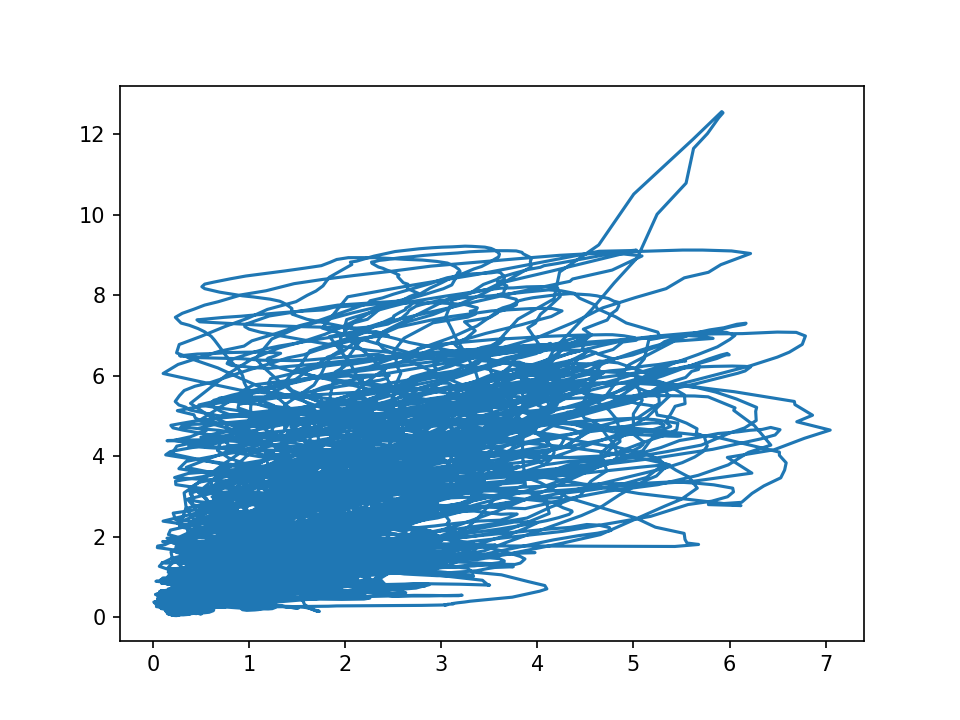

In [15]:
fig = plt.figure()
plt.plot(pilot_acc_calc,pilot_accF)

<IPython.core.display.Javascript object>


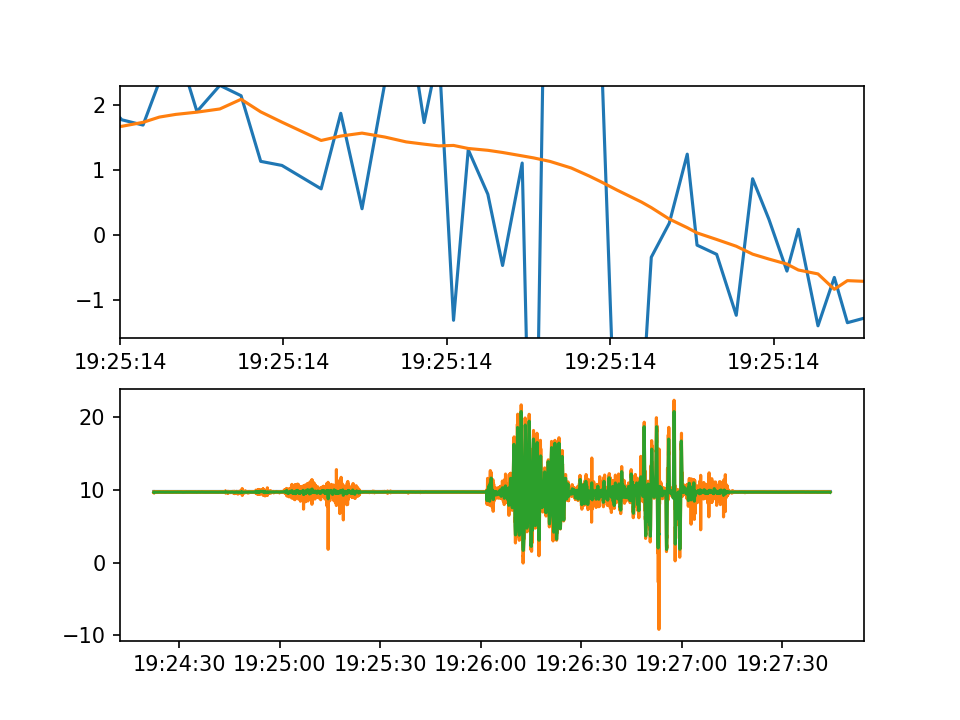

In [6]:
gvec_wing = utils.qvec((wing.q0,-wing.q1,-wing.q2,-wing.q3),(wing.gx,wing.gy,wing.gz))
gvec_pilot = utils.qvec((pilot.q0,-pilot.q1,-pilot.q2,-pilot.q3),(pilot.gx,pilot.gy,pilot.gz))
fig = plt.figure()
plt.subplot(211)
#plt.plot(gvec_wing[0])
plt.plot(g_app_vec_wing[0])
plt.plot(g_appx_wing)
#plt.plot(g_app_vec_wing[1])
#plt.plot(g_appy_wing)
#plt.plot(gvec_wing[1])
#plt.plot(gvec_pilot[0])
#plt.plot(gvec_pilot[1])
plt.subplot(212)
plt.plot(gvec_wing[2])
plt.plot(g_app_vec_wing[2])
plt.plot(g_appz_wing)

In [40]:
pilot

,ax,ay,az,gx,gy,gz,q0,q1,q2,q3,s,iqsq,pitch,roll,heading,bad
2021-01-05 19:24:22.416930,0.97,0.89,0.00,-0.70,-0.95,-9.73,56.0,-10451.0,-12579.0,991.0,255.0,3.725229e-09,-5.580045,-4.124025,349.239992,False
2021-01-05 19:24:22.425930,0.96,0.81,-0.04,-0.69,-0.88,-9.74,23.0,-10452.0,-12582.0,944.0,255.0,3.725190e-09,-5.179844,-4.091791,349.247900,False
2021-01-05 19:24:22.434930,0.96,0.81,-0.04,-0.69,-0.88,-9.74,23.0,-10452.0,-12582.0,944.0,255.0,3.725190e-09,-5.179844,-4.091791,349.247900,False
2021-01-05 19:24:22.445930,0.96,0.74,-0.06,-0.68,-0.81,-9.74,8.0,10454.0,12584.0,-891.0,255.0,3.725267e-09,-4.756131,-4.022498,349.267831,False
2021-01-05 19:24:22.456930,0.95,0.68,-0.11,-0.67,-0.73,-9.75,38.0,10456.0,12586.0,-833.0,255.0,3.725357e-09,-4.310067,-3.925426,349.289067,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-05 19:27:44.233930,-0.07,-0.38,-0.10,0.25,0.14,-9.80,170.0,-4635.0,-15713.0,-175.0,255.0,3.725212e-09,0.837489,1.486698,1382.859001,False
2021-01-05 19:27:44.246930,-0.06,-0.39,-0.05,0.25,0.15,-9.80,169.0,-4635.0,-15713.0,-186.0,255.0,3.725161e-09,0.913247,1.501740,1382.857898,False
2021-01-05 19:27:44.255930,-0.05,-0.41,-0.04,0.25,0.16,-9.80,168.0,-4636.0,-15712.0,-194.0,255.0,3.725431e-09,0.968809,1.510985,1382.865779,False
2021-01-05 19:27:44.268930,-0.05,-0.42,-0.02,0.25,0.17,-9.80,167.0,-4636.0,-15712.0,-200.0,255.0,3.725403e-09,1.011031,1.516142,1382.865177,False


<IPython.core.display.Javascript object>


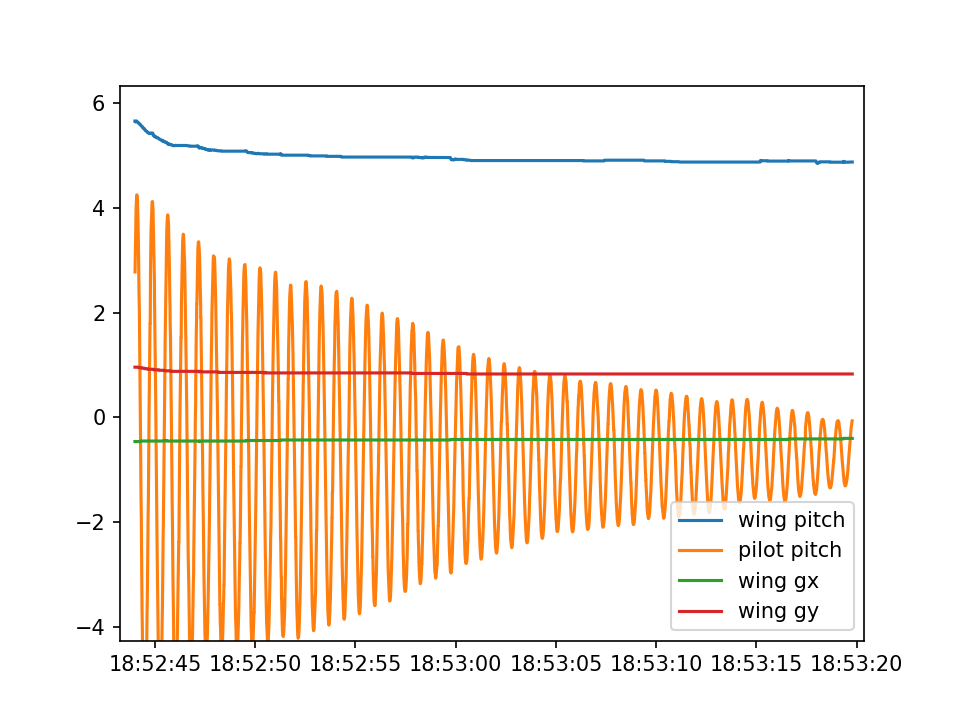

In [13]:
t0 = pandas.Timestamp('2021-01-01 18:52:44')

pilot_fit = pilot[t0:]
wing_fit = wing[t0:]

fig = plt.figure()
plt.plot(wing_fit.pitch, label = 'wing pitch')
plt.plot(pilot_fit.pitch, label = 'pilot pitch')
plt.plot(wing_fit.gx, label = 'wing gx')
plt.plot(wing_fit.gy, label = 'wing gy')
plt.legend()

<IPython.core.display.Javascript object>


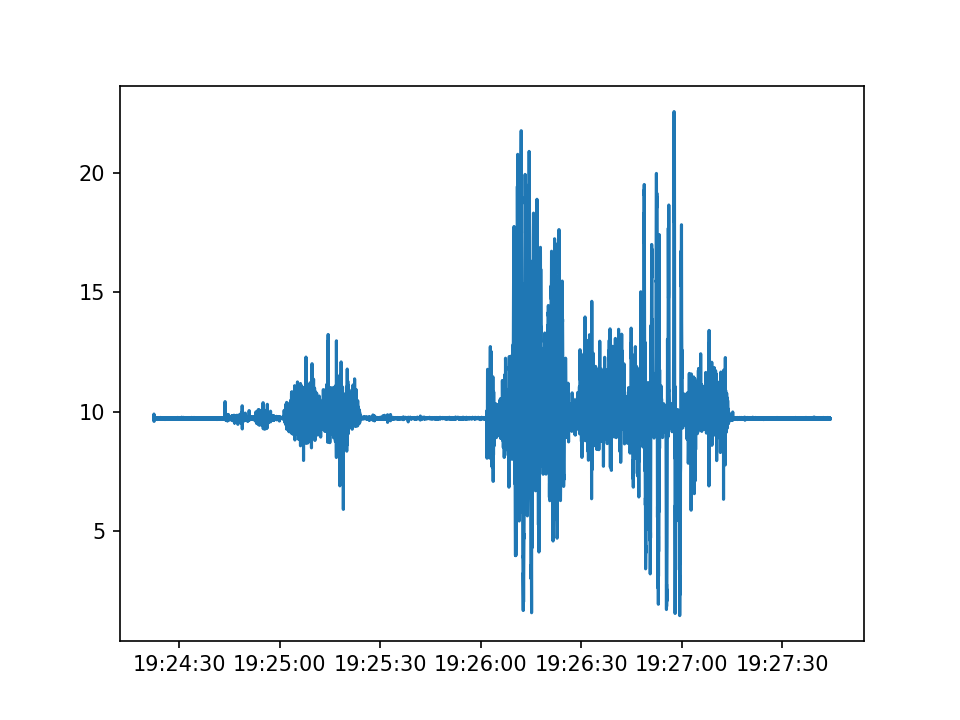

In [5]:
g_app_wing = (wing.gx_app**2+wing.gy_app**2+wing.gz_app**2)**0.5
fig = plt.figure()
plt.plot(g_app_wing)